<a href="https://colab.research.google.com/github/RebatiGaire/TensorflowInPractice/blob/master/sunspot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import csv

2.2.0-rc3


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-19 15:23:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-04-19 15:23:59 (4.62 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
time_step = []
temp = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter= ',')
  next(reader)
  step = 0
  for row in reader:
    temp.append(float(row[1]))
    time_step.append(step)
    step += 1

series = np.array(temp)
time = np.array(time_step)



In [0]:
def plot_series(time, series, start= 0, end= None, format='-'):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Temperature")
  plt.grid(True)

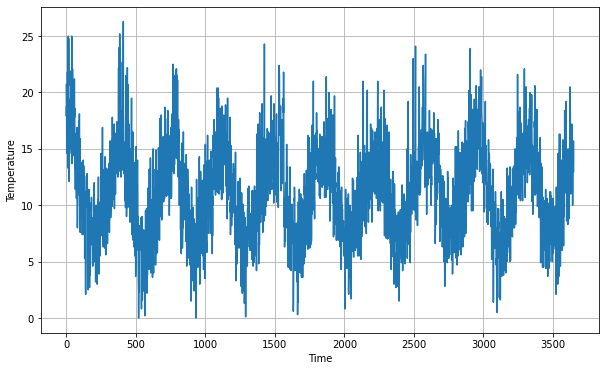

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis= -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift= 1, drop_remainder= True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)




In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder= True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast
  

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 32, kernel_size= 5, strides = 1, padding= 'causal', activation = 'relu', input_shape= [None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences= True),
        tf.keras.layers.Dense(30, activation= 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400),                            
       ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(lr= 1e-8, momentum= 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 3s 290ms/step - loss: 97.4349 - mae: 97.9775 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 3s 294ms/step - loss: 94.1959 - mae: 94.8161 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 3s 295ms/step - loss: 89.3360 - mae: 89.9622 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 3s 292ms/step - loss: 83.4212 - mae: 84.0530 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 3s 336ms/step - loss: 76.6109 - mae: 77.2872 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 5s 530ms/step - loss: 69.0874 - mae: 69.7743 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 4s 370ms/step - loss: 60.9044 - mae: 61.6057 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 3s 294ms/step - loss: 52.0481 - mae: 52.

(1e-08, 0.0001, 0.0, 30.0)

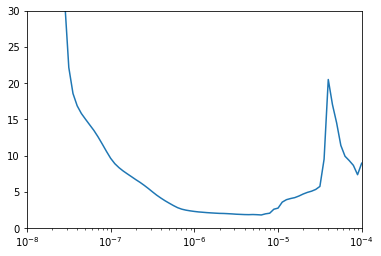

In [21]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 123ms/step - loss: 9.8219 - mae: 10.4700
Epoch 2/150
25/25 [==============================] - 3s 126ms/step - loss: 2.5190 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 3s 125ms/step - loss: 1.9512 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 3s 125ms/step - loss: 1.8609 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 3s 126ms/step - loss: 1.8209 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 3s 124ms/step - loss: 1.7905 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 3s 123ms/step - loss: 1.7667 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 3s 124ms/step - loss: 1.7387 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 3s 125ms/step - loss: 1.7173 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 3s 124ms/step - loss: 1.6987 - mae: 2.1483
Epoch 11/150
25/25 [==================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

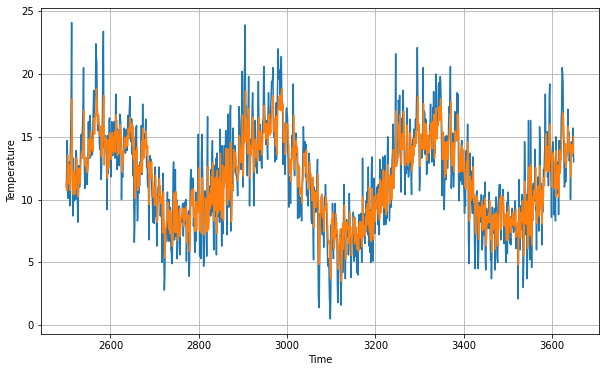

In [31]:
plt.figure(figsize= (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7797481

In [33]:
print(rnn_forecast)

[11.328999  10.703278  12.122135  ... 13.6022835 13.795011  15.007327 ]
